<H2>Data Overview</H2>
In this competition, we need to predict if two people share a kinship relationship or not based on their facial images. The data is provided by Families In the Wild (FIW), the largest and most comprehensive image database for automatic kinship recognition.

FIW's dataset is obtained from publicly available images from celebrities.

<H2>File Descriptions </H2>

*   train-faces.zip - the training set is divided in Families (F0123), then individuals (MIDx). Images in the same MIDx folder belong to the same person. Images in the same F0123 folder belong to the same family.

* train.csv - training labels. Remember, not every individual in a family shares a kinship relationship. For example, a mother and father are kin to their children, but not to each other.

* test-faces.zip - the test set contains face images of unknown individuals

* sample_submission.csv - a sample submission file in the correct format. The column img_pair describes the pair of images, i.e., abcdef-ghijkl means the pair of images abcdef.jpg and ghijkl.jpg. Your goal is to predict if each pair of images in test-faces are related or not, where 1 means related and 0 means unrelated.
   



In [0]:
# we used VGGFace file from the below github which  has some models works better for Face Identification
!git clone https://github.com/rcmalli/keras-vggface.git

Cloning into 'keras-vggface'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 273 (delta 7), reused 7 (delta 3), pack-reused 251
Receiving objects: 100% (273/273), 6.03 MiB | 8.20 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [0]:
import os,shutil
for file_ in os.listdir('keras-vggface'):
    if '.*' not in file_:
        try:
            shutil.move('keras-vggface/'+file_,'.')
        except:
            print(9) 

In [0]:
from collections import defaultdict
from glob import glob
from random import choice, sample
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
import gc, psutil, cv2, random, base64, h5py, os,shutil
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 9999
pd.options.display.float_format = '{:20, .2f}'.format
from keras import backend as K

from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add
from keras_vggface.vggface import VGGFace
from pathlib import Path

from PIL import Image
from io import BytesIO
from IPython.display import HTML
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras.layers import Conv1D, BatchNormalization,Reshape, LeakyReLU
from keras.preprocessing import image
from keras.optimizers import Adam,SGD,rmsprop
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Conv2D,MaxPooling1D,GlobalAveragePooling1D,LSTM
from keras.models import Model
from keras.losses import binary_crossentropy
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from keras import regularizers
%pylab inline
import matplotlib.image as mpimg

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [0]:
import shutil
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
# path='drive/My Drive/AAIC/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


<h1>Uploading Kaggle credentials 

In [0]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


<H1>Downloading the Dataset

In [0]:
!kaggle competitions download -c recognizing-faces-in-the-wild

  0% 0.00/77.6k [00:00<?, ?B/s]
100% 77.6k/77.6k [00:00<00:00, 33.4MB/s]
 73% 25.0M/34.1M [00:00<00:00, 23.0MB/s]
100% 34.1M/34.1M [00:00<00:00, 49.6MB/s]
 95% 65.0M/68.6M [00:01<00:00, 32.2MB/s]
100% 68.6M/68.6M [00:01<00:00, 67.3MB/s]
  0% 0.00/156k [00:00<?, ?B/s]
100% 156k/156k [00:00<00:00, 185MB/s]


In [0]:
%%time
%%capture
!unzip test.zip -d test 

CPU times: user 606 ms, sys: 85.8 ms, total: 692 ms
Wall time: 3.71 s


In [0]:
print("The no of test images:",len(os.listdir('test')))

The no of test images: 6282


In [0]:
%%time
%%capture
!unzip train.zip -d train

CPU times: user 1.33 s, sys: 204 ms, total: 1.53 s
Wall time: 5.82 s


In [0]:
print("The no of families:",len(os.listdir('train')))
# here it contains both the folders and pics

The no of families: 470


<H1>Preparing of Data

In [0]:
train_file_path = "train_relationships.csv"
train_folders_path = "train/"
test_path = "test/"
train_df=pd.read_csv(train_file_path)
sample_sub_df=pd.read_csv('sample_submission.csv')
# The above cell contain only the variables which we change in future

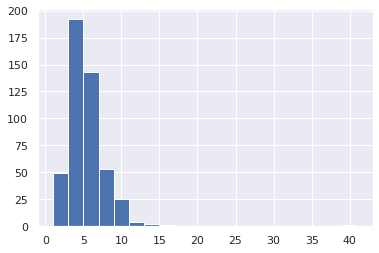

In [0]:
k=[]
for e in os.listdir(train_folders_path):
    k.append(len(os.listdir(train_folders_path+e)))
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
sns.set()
plt.hist(k,bins=20)
plt.show()    

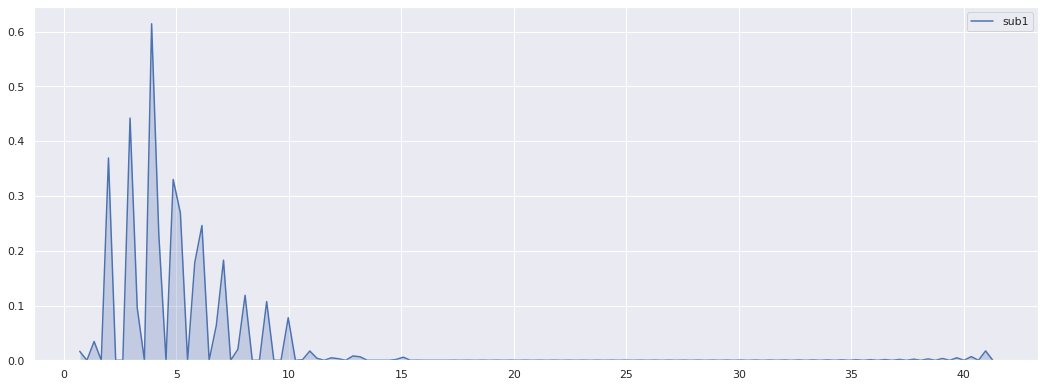

In [0]:
sns.set(rc={'figure.figsize':(18,6.5)})
sns.kdeplot(k,label="sub1",shade=True,bw=.1)

In [0]:
# out of 470 families we are splitting 80% train  and 20% test
 # 20% cv will be removed from train

In [0]:
fam_list = os.listdir(train_folders_path)

In [0]:
from sklearn.model_selection import train_test_split
x_train ,x_test = train_test_split(fam_list,test_size=0.2) 
x_train ,x_cv = train_test_split(x_train,test_size=0.2) 

In [0]:
print(len(x_train))
print(len(x_test))
print(len(x_cv))

300
94
76


In [0]:
all_images = glob(train_folders_path + "*/*/*.jpg")
#  https://stackoverflow.com/questions/4843158/check-if-a-python-list-item-contains-a-string-inside-another-string
train_images = [x for x in all_images if any([e in x for e in x_train])]
test_images = [x for x in all_images if any([e in x for e in x_test])]
cv_images = [x for x in all_images if any([e in x for e in x_cv])]

In [0]:
cv_images=[]
for x in all_images :
    if any(x in e for e in x_cv):
        cv_images.append(x)

In [0]:
print(len(train_images))
print(len(test_images))
print(len(cv_images))

7306
3172
12379


In [0]:
ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]

train_person_to_images_map = defaultdict(list)
for x in train_images:
    train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

val_person_to_images_map = defaultdict(list)
for x in cv_images:
    val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

test_person_to_images_map = defaultdict(list)
for x in test_images:
    test_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)


In [0]:
# val_famillies = "F09"
# train_images = [x for x in all_images if val_famillies not in x]
# val_images = [x for x in all_images if val_famillies in x]
relationships = pd.read_csv(train_file_path)
relationships = list(zip(relationships.p1.values, relationships.p2.values))
relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]

In [0]:
# train = [x for x in relationships if val_famillies not in x[0]]
val = [x for x in relationships if any([ e in x[0] for e in x_cv ])]
train = [x for x in relationships if any([e in x[0] for e in x_train ])]
test = [x for x in relationships if any([ e in x[0] for e in x_test ])]

In [0]:
print(len(train))
print(len(test))
print(len(val))

2149
701
512


In [0]:
val[0]

('F0010/MID1', 'F0010/MID3')

In [0]:
# all the images are of shape 224, 224, 3 as observed in EDA

<H1>Common plotting error functions

In [0]:
def read_img(path):
    '''
    read_img takes the path as input and reads the data and calls the preprocess_input function which removes 
    the unnecessary pixels and gives the face relevant pixels

    '''
    img = image.load_img(path, target_size=(224, 224))
    img = np.array(img).astype(np.float)
    return preprocess_input(img, version=2)

<H1>Model  Architectures

In [0]:
def gen(list_tuples, person_to_images_map, batch_size=16):
    '''
    This function is use to generate the generators .
    It takes input of personid
    '''
    ppl = list(person_to_images_map.keys())
    while True:
        batch_tuples = sample(list_tuples, batch_size // 2)
        labels = [1] * len(batch_tuples)
        while len(batch_tuples) < batch_size:
            p1 = choice(ppl)
            # https://www.geeksforgeeks.org/python-numbers-choice-function/  so p1 ,p2 contains the random member id'
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)

        for x in batch_tuples:
            if not len(person_to_images_map[x[0]]):
                print(x[0])
        # the above line prints the member id if the meber doesn't exist 
        # it is just to keep a safe check                 

        X1 = [choice(person_to_images_map[x[0]]) for x in batch_tuples]
        X1 = np.array([read_img(x) for x in X1])
        # X1 is a numpy array in which X1[0] is the numpy array of x[0] images after preprocessed
        #                   X1[1] is the numpy array of x[1] images after preprocessed

        X2 = [choice(person_to_images_map[x[1]]) for x in batch_tuples]
        X2 = np.array([read_img(x) for x in X2])

        # https://pythontips.com/2013/09/29/the-python-yield-keyword-explained/
        yield [X1, X2], labels

In [0]:
def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)  

In [0]:
def siamese_model():
    input_1 = Input(shape=(224, 224, 3))
    input_2 = Input(shape=(224, 224, 3))
    base_model = VGGFace(model='resnet50', include_top=False,input_shape=(224, 224, 3))

    for x in base_model.layers[:-3]:
        x.trainable = True

    x1 = base_model(input_1)
    x2 = base_model(input_2)

    x1 = Concatenate(axis=-1)([GlobalAvgPool2D()(x1), GlobalAvgPool2D()(x1)])
    x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])
    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])  
    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4  = Subtract()([x1_, x2_])    
    x   = Concatenate(axis=-1)([x4, x3])
    x   = Reshape(input_shape=(8192,), target_shape=(8192, 1))(x)
    
    """    x   = Conv1D(filters=100, kernel_size=3 ,strides=3,input_shape=( 8192,1),dilation_rate = 1,
                  activation= 'relu',kernel_regularizer=l2(1e-5),
                   kernel_initializer='uniform',
                 bias_initializer=initialize_bias)(x)
    x   = Conv1D( 100,3,activation= 'relu', kernel_initializer= 'he_uniform')(x)
    x   = Flatten()(x)
  
    x   = Dense(100, activation="relu")(x) 
    x   = Dropout(0.2)(x)   
    x   = Dense(128, activation="relu")(x) """
    x = Conv1D(filters=100,
               kernel_size=8,
               strides=8,input_shape=( 8192,1),
               activation='relu',
               padding='same')(x)
    x   = Conv1D( 100,8,activation= 'relu')(x)
    x   = LSTM(128, return_sequences=True)(x)
    x   = Dropout(0.1)(x)
    x   = LSTM(128, return_sequences=True)(x)
    x   = BatchNormalization ()(x)
    x   = Flatten()(x)
    x   = Dense(100, activation="relu")(x) 
    
    out = Dense(1, activation="sigmoid")(x)
    model = Model([input_1, input_2], out)
    model.compile(loss="binary_crossentropy", metrics=['acc',auc], optimizer=Adam(0.00001,decay=1e-6))
    model.summary()

    return model

<H1>Best Model Training 

In [0]:
gen_train = gen(train, train_person_to_images_map, batch_size=8)
gen_test = gen(test, test_person_to_images_map, batch_size=8)
gen_val = gen(val, val_person_to_images_map, batch_size=8)
# gen_train, gen_val are the generators

In [0]:
checkpoint = ModelCheckpoint('model_best_checkpoint.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=20, verbose=1)
callbacks_list = [checkpoint, reduce_on_plateau]

In [0]:
from glob import glob
from random import choice, sample
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D
from keras.models import Model
from keras.preprocessing import image
from keras.optimizers import Adam
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
from keras.models import load_model

In [0]:
import gc
gc.collect()

def final_model():
    global model
    try:
        model=load_model('drive/My Drive/AAIC/north-east-smile/final/model_best_checkpoint.h5',custom_objects={ 'auc': auc })
    except:    
        curr_model = siamese_model()
        curr_model_hist=curr_model.fit_generator(gen_train, use_multiprocessing=True,
                        validation_data=gen_val, epochs=20, verbose=1,
                        workers = 4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)
        model =curr_model_hist.model
    return model

In [0]:
try:
    shutil.copy('model_best_checkpoint.h5','/content/drive/My Drive/AAIC/north-east-smile/final')
except:
    print("The folder not exist to copy")    

The folder not exist to copy


In [0]:
import progressbar
import pdb
def metric(list_tuples, person_to_images_map, batch_size=16):
    global model
    ppl = list(person_to_images_map.keys())
    batch_size = 8
    predictions=[]
    labels1=[]
    pro=progressbar.ProgressBar()
    for i in pro(range(0,len(list_tuples),batch_size)):
        batch_tuples = list_tuples[i:i+batch_size]
        labels = [1] * len(batch_tuples)
        while len(batch_tuples) < 2*batch_size:
            p1 = choice(ppl)
            # https://www.geeksforgeeks.org/python-numbers-choice-function/  so p1 ,p2 contains the random member id'
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)


        X1 = [x[0] for x in batch_tuples]
        fpath=[]
        for e in X1:
            try:
                fpath.append(e+"/"+choice(os.listdir('train/'+e)))  
            except:
                pdb.set_trace()    
        X1 = np.array([read_img('train/' + x) for x in fpath])

        fpath=[]
        X2 = [x[1] for x in batch_tuples]
        for e in X2:
            try:
                fpath.append(e+"/"+choice(os.listdir('train/'+e)))
            except:
                pdb.set_trace()
        X2 = np.array([read_img('train/' + x) for x in fpath])

        pred = model.predict([X1, X2]).ravel().tolist()
        predictions.extend(pred)
        labels1.extend(labels)
    return roc_auc_score( labels1,predictions)

In [0]:
final_model()
# can you create a function, which takes two images and returns the output if they are samer not? i.e.
# ?, can you do that?
# yeah 














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    




In [0]:
# test_metric = metric(test,test_person_to_images_map,batch_size=8)
# print(train_metric ,  val_metric ,  test_metric )

In [0]:
train_metric = metric(train,train_person_to_images_map,batch_size=8)
test_metric = metric(test,test_person_to_images_map,batch_size=8)
val_metric = metric(val,val_person_to_images_map,batch_size=8)
print(train_metric ,  val_metric ,  test_metric )

100% (269 of 269) |######################| Elapsed Time: 0:08:10 Time:  0:08:10
100% (88 of 88) |########################| Elapsed Time: 0:02:38 Time:  0:02:38
100% (64 of 64) |########################| Elapsed Time: 0:01:56 Time:  0:01:56


0.8702119045279788 0.8723258972167969 0.8522196014180592


In [0]:
print(train_metric ,  val_metric ,  test_metric )
# where is the final function?

0.8680867051960713 0.8723258972167969 0.8522196014180592


In [0]:
submission = pd.read_csv('sample_submission.csv')

In [0]:
submission.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0
1,face05750.jpg-face00898.jpg,0
2,face05820.jpg-face03938.jpg,0
3,face02104.jpg-face01172.jpg,0
4,face02428.jpg-face05611.jpg,0


In [0]:
def chunker(seq, size=32):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

test_path='train/F0002/MID1/'
test_path=''
def predict_images(img1,img2):
    global submission
    d = {'img_pair': img1+"-"+img2}
    submission  = pd.DataFrame(data=d,index=[0])
    predictions = []
    for batch in (chunker(submission.img_pair.values)):
        X1 = [x.split("-")[0] for x in batch]
        X1 = np.array([read_img(test_path + x) for x in X1])

        X2 = [x.split("-")[1] for x in batch]
        X2 = np.array([read_img(test_path + x) for x in X2])
        print(X1.shape, X2.shape)
        pred = model.predict([X1, X2]).ravel().tolist()
        # what is your kaggle socre? and rank?
        # i'll open i frgot the score

        # 0.906
# you submit these functions it will get accepted
# sir  i didn't understood i have submitted in kaggle competetion 
    return pred

In [0]:
predict_images("Capture1.PNG","Capture2.PNG")
# can you display these two images
#ok 

(1, 224, 224, 3) (1, 224, 224, 3)


[0.8035022020339966]

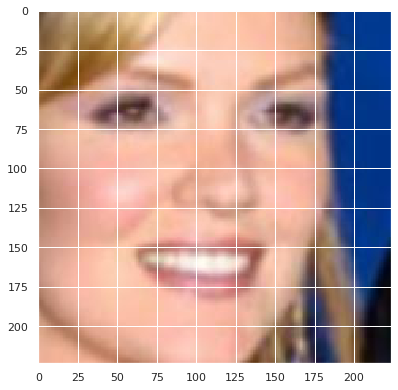

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# can i download the images and show you or plot in noebook 
img = mpimg.imread('test/face05508.jpg')
imgplot = plt.imshow(img)

plt.show()

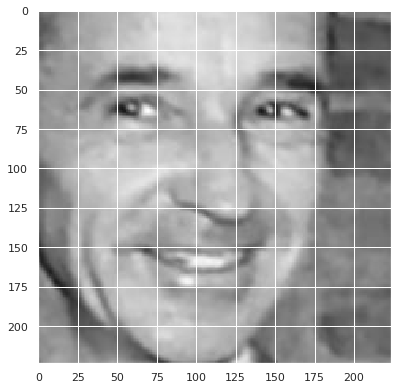

In [0]:
#upload those two pics and test your model 
img = mpimg.imread('test/face01210.jpg')
imgplot = plt.imshow(img)
plt.show()

In [0]:
predict_images("face05508.jpg","face01210.jpg")
# can you display these two images
#ok 

[0.0406334325671196]

In [0]:
predict_images("P00009_face3.jpg","P00010_face4.jpg")

[0.9997027516365051]

<H1> References : </H1>
Joseph P Robinson, Ming Shao, Hongfu Liu, Yue Wu, Timothy Gillis, and Yun Fu. "Visual Kinship Recognition of Families In the Wild" IEEE TPAMI Special Edition: Computational Face (2018). paper

Joseph P Robinson, Ming Shao, Handong Zhao, Yue Wu, Timothy Gillis, Yun Fu. "Recognizing Families In the Wild (RFIW): Data Challenge Workshop in conjunction with ACM MM 2017," ACM Multimedia Conference: Workshop on RFIW (2017). paper

Shuyang Wang, Joseph P Robinson, and Yun Fu. “Kinship Verification on Families in the Wild with Marginalized Denoising Metric Learning,” in IEEE Automatic Face and Gesture Recognition (2017). paper

Joseph P Robinson, Ming Shao, Yue Wu, and Yun Fu. “Families In the Wild (FIW): large-scale kinship image database and benchmarks." in ACM on Multimedia Conference (2016). paper

https://www.kaggle.com/ranjitkumar1/recognizing-face-with-one-shot-learning

https://github.com/rcmalli/keras-vggface.git

